# Planning

- [x] Planning - Business Question
- [x] Acquire the data
- [x] Prepare / Process the Data
- [x] EDA
- [x] Modeling
- [ ] Delivery
- [ ] Maintenance

Install the necessary packages from the terminal:

> pip install pandas matplotlib seaborn nltk scikit-learn wordcloud xgboost

In [1]:
# setting the random seed for reproducibility
import random
random.seed(493)

# for manipulating dataframes
import pandas as pd
import numpy as np

# for visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# for natural language processing
import unicodedata
import re
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from wordcloud import WordCloud
from collections import Counter

# for modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# to print out all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Acquire the Data

In [2]:
# Read a csv file
df = pd.read_csv('../data/amazon_reviews.csv')

# Prepare / Process the Data

Let's take a peek!

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54598 entries, 0 to 54597
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              54598 non-null  object
 1   userName              54593 non-null  object
 2   content               54596 non-null  object
 3   score                 54598 non-null  int64 
 4   thumbsUpCount         54598 non-null  int64 
 5   reviewCreatedVersion  49187 non-null  object
 6   at                    54598 non-null  object
 7   appVersion            49187 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [4]:
df.describe()

,score,thumbsUpCount
count,54598.000000,54598.000000
mean,2.463076,12.865911
std,1.663866,82.932276
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,1.000000
75%,4.000000,2.000000
max,5.000000,5660.000000


In [5]:
df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,d28b66b6-724d-4dbd-b93d-5513648b797a,Oliver Loughran,Great,4,0,NaN,2024-06-30 20:52:41,NaN
1,40a208e7-2ee2-4c95-b137-a85c51eb9b5c,Ernesto G,Una aplicación confiable y cuyas entregas se realizan normalmente de manera rápida.,5,0,28.12.2.100,2024-06-30 20:28:09,28.12.2.100
2,5cca904b-4166-4dac-9469-b6455e039ff1,Forrest Hawkins,"Since we moved to an assisted living facility because of my wife's stroke, with my need to stay with her, we have depended on Amazon for shopping. I have learned to overcome much of the lack of help.",5,0,28.13.6.100,2024-06-30 20:21:06,28.13.6.100
3,c1e3e586-124a-4519-adbd-72ca2f9135ff,A Google user,Cd Nooreew Soomoog.I Think that,3,0,28.12.2.100,2024-06-30 19:55:24,28.12.2.100
4,c68332c6-2971-4f2b-b085-5545bb3b6df2,Certified Cat,"I love it can find ALMOST EVERYTHING I say that because they don't have the flipper 0 due to it ""being a credit card ripper"" but it's not and nothing like that",4,0,28.12.2.100,2024-06-30 19:21:13,28.12.2.100


In [6]:
def show_ends(df):
    return pd.concat([df.head(), df.tail()])

## Value Counts

Let's see what classes we're dealing with.

In [7]:
def get_values(df, columns):
    """
    Take a dataframe and a list of columns and
    returns the value counts for the columns.
    """
    for column in columns:
        print(column)
        print('=====================================')
        print(df[column].value_counts(dropna=False))
        print('\n')

def show_values(df, param):
    if param == 'all':
        get_values(df, df.columns)
    else:
        get_values(df, param) 

show_values(df, ['score'])

score
score
1    26105
5    13014
2     6773
3     5066
4     3640
Name: count, dtype: int64




## Column Names

Let's make sure there are no surprises in the column names like a leading or trailing space.

In [8]:
df.columns

Index(['reviewId', 'userName', 'content', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'appVersion'],
      dtype='object')

Let's only keep the relevant columns for now.

In [9]:
df = df[['reviewId',
          'at',
          'content',
          'score',
        ]]

In [10]:
show_ends(df)

,reviewId,at,content,score
0,d28b66b6-724d-4dbd-b93d-5513648b797a,2024-06-30 20:52:41,Great,4
1,40a208e7-2ee2-4c95-b137-a85c51eb9b5c,2024-06-30 20:28:09,Una aplicación confiable y cuyas entregas se realizan normalmente de manera rápida.,5
2,5cca904b-4166-4dac-9469-b6455e039ff1,2024-06-30 20:21:06,"Since we moved to an assisted living facility because of my wife's stroke, with my need to stay with her, we have depended on Amazon for shopping. I have learned to overcome much of the lack of help.",5
3,c1e3e586-124a-4519-adbd-72ca2f9135ff,2024-06-30 19:55:24,Cd Nooreew Soomoog.I Think that,3
4,c68332c6-2971-4f2b-b085-5545bb3b6df2,2024-06-30 19:21:13,"I love it can find ALMOST EVERYTHING I say that because they don't have the flipper 0 due to it ""being a credit card ripper"" but it's not and nothing like that",4
54593,ac82191a-e776-42a0-8e30-91eabb763968,2023-01-16 06:12:14,"Amazon Smile donates. Make sure you get all set up, and learn how it works. Donate without lifting a finger.",5
54594,3aa6af38-b044-4257-9cf3-b94c437da0ef,2021-09-24 12:01:29,"After having problems with the app and having to reinstall it, it's now working fine.",5
54595,727ec38a-c633-48f4-a302-66e52740a43c,2023-05-15 18:27:24,"Used to be great. Got greedy, they ruined the music app. No longer a customer.",1
54596,615a9643-cd36-4010-9a81-8763bac11ddf,2023-06-11 15:24:08,New search bar location sucks. At least give me the option to have it on the top or the bottom.,2
54597,6b818e48-406b-4b9d-88c6-759152019a96,2022-05-08 17:59:37,for me personally I use Amazon prime due to being disabled not only that having it delivered to your door makes it so easy 90 percent of my shopping is now online,5


## Date-time

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54598 entries, 0 to 54597
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   reviewId  54598 non-null  object
 1   at        54598 non-null  object
 2   content   54596 non-null  object
 3   score     54598 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


Let's convert the date to date time

In [12]:
# convert 'at' column to datetime
df['at'] = pd.to_datetime(df['at'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54598 entries, 0 to 54597
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   reviewId  54598 non-null  object        
 1   at        54598 non-null  datetime64[ns]
 2   content   54596 non-null  object        
 3   score     54598 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.7+ MB


## Clean up missing values

In [14]:
def show_missing(df):
    """
    Takes a dataframe and returns a dataframe with stats
    on missing and null values with their percentages.
    """
    null_count = df.isnull().sum()
    null_percentage = (null_count / df.shape[0]) * 100
    empty_count = pd.Series(((df == ' ') | (df == '')).sum())
    empty_percentage = (empty_count / df.shape[0]) * 100
    nan_count = pd.Series(((df == 'nan') | (df == 'NaN')).sum())
    nan_percentage = (nan_count / df.shape[0]) * 100
    dfx = pd.DataFrame({'num_missing': null_count, 'missing_percentage': null_percentage,
                         'num_empty': empty_count, 'empty_percentage': empty_percentage,
                         'nan_count': nan_count, 'nan_percentage': nan_percentage})
    return dfx

show_missing(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
reviewId,0,0.000000,0,0.0,0,0.0
at,0,0.000000,0,0.0,0,0.0
content,2,0.003663,0,0.0,0,0.0
score,0,0.000000,0,0.0,0,0.0


Let's do a little clean-up.

In [15]:
# remove missing content records
df = df[df['content'].notnull()]

In [16]:
show_missing(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
reviewId,0,0.0,0,0.0,0,0.0
at,0,0.0,0,0.0,0,0.0
content,0,0.0,0,0.0,0,0.0
score,0,0.0,0,0.0,0,0.0


## Replace "score" column

In [17]:
# Create the 'rating' column based on 'score' values
df['rating'] = np.where(df['score'] == 3, 'neutral', np.where(df['score'] > 3, 'good', 'bad'))

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54596 entries, 0 to 54597
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   reviewId  54596 non-null  object        
 1   at        54596 non-null  datetime64[ns]
 2   content   54596 non-null  object        
 3   score     54596 non-null  int64         
 4   rating    54596 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.5+ MB


In [19]:
df = df.drop(columns=['score'])

In [20]:
df.head()

,reviewId,at,content,rating
0,d28b66b6-724d-4dbd-b93d-5513648b797a,2024-06-30 20:52:41,Great,good
1,40a208e7-2ee2-4c95-b137-a85c51eb9b5c,2024-06-30 20:28:09,Una aplicación confiable y cuyas entregas se realizan normalmente de manera rápida.,good
2,5cca904b-4166-4dac-9469-b6455e039ff1,2024-06-30 20:21:06,"Since we moved to an assisted living facility because of my wife's stroke, with my need to stay with her, we have depended on Amazon for shopping. I have learned to overcome much of the lack of help.",good
3,c1e3e586-124a-4519-adbd-72ca2f9135ff,2024-06-30 19:55:24,Cd Nooreew Soomoog.I Think that,neutral
4,c68332c6-2971-4f2b-b085-5545bb3b6df2,2024-06-30 19:21:13,"I love it can find ALMOST EVERYTHING I say that because they don't have the flipper 0 due to it ""being a credit card ripper"" but it's not and nothing like that",good


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54596 entries, 0 to 54597
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   reviewId  54596 non-null  object        
 1   at        54596 non-null  datetime64[ns]
 2   content   54596 non-null  object        
 3   rating    54596 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.1+ MB


## Dedupe

In [22]:
# remove dupes
df = df.drop_duplicates()

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54482 entries, 0 to 54597
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   reviewId  54482 non-null  object        
 1   at        54482 non-null  datetime64[ns]
 2   content   54482 non-null  object        
 3   rating    54482 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.1+ MB


In [24]:
show_ends(df)

,reviewId,at,content,rating
0,d28b66b6-724d-4dbd-b93d-5513648b797a,2024-06-30 20:52:41,Great,good
1,40a208e7-2ee2-4c95-b137-a85c51eb9b5c,2024-06-30 20:28:09,Una aplicación confiable y cuyas entregas se realizan normalmente de manera rápida.,good
2,5cca904b-4166-4dac-9469-b6455e039ff1,2024-06-30 20:21:06,"Since we moved to an assisted living facility because of my wife's stroke, with my need to stay with her, we have depended on Amazon for shopping. I have learned to overcome much of the lack of help.",good
3,c1e3e586-124a-4519-adbd-72ca2f9135ff,2024-06-30 19:55:24,Cd Nooreew Soomoog.I Think that,neutral
4,c68332c6-2971-4f2b-b085-5545bb3b6df2,2024-06-30 19:21:13,"I love it can find ALMOST EVERYTHING I say that because they don't have the flipper 0 due to it ""being a credit card ripper"" but it's not and nothing like that",good
54593,ac82191a-e776-42a0-8e30-91eabb763968,2023-01-16 06:12:14,"Amazon Smile donates. Make sure you get all set up, and learn how it works. Donate without lifting a finger.",good
54594,3aa6af38-b044-4257-9cf3-b94c437da0ef,2021-09-24 12:01:29,"After having problems with the app and having to reinstall it, it's now working fine.",good
54595,727ec38a-c633-48f4-a302-66e52740a43c,2023-05-15 18:27:24,"Used to be great. Got greedy, they ruined the music app. No longer a customer.",bad
54596,615a9643-cd36-4010-9a81-8763bac11ddf,2023-06-11 15:24:08,New search bar location sucks. At least give me the option to have it on the top or the bottom.,bad
54597,6b818e48-406b-4b9d-88c6-759152019a96,2022-05-08 17:59:37,for me personally I use Amazon prime due to being disabled not only that having it delivered to your door makes it so easy 90 percent of my shopping is now online,good


## Subset of one year

In [25]:
start_date = pd.to_datetime('2023-07-01')
end_date = pd.to_datetime('2024-07-01')

dfx = df[(df['at'] >= start_date) & (df['at'] <= end_date)]
show_ends(dfx)

,reviewId,at,content,rating
0,d28b66b6-724d-4dbd-b93d-5513648b797a,2024-06-30 20:52:41,Great,good
1,40a208e7-2ee2-4c95-b137-a85c51eb9b5c,2024-06-30 20:28:09,Una aplicación confiable y cuyas entregas se realizan normalmente de manera rápida.,good
2,5cca904b-4166-4dac-9469-b6455e039ff1,2024-06-30 20:21:06,"Since we moved to an assisted living facility because of my wife's stroke, with my need to stay with her, we have depended on Amazon for shopping. I have learned to overcome much of the lack of help.",good
3,c1e3e586-124a-4519-adbd-72ca2f9135ff,2024-06-30 19:55:24,Cd Nooreew Soomoog.I Think that,neutral
4,c68332c6-2971-4f2b-b085-5545bb3b6df2,2024-06-30 19:21:13,"I love it can find ALMOST EVERYTHING I say that because they don't have the flipper 0 due to it ""being a credit card ripper"" but it's not and nothing like that",good
54571,89cfeaf8-e12d-4489-a123-ae8d50af8351,2024-01-31 00:07:18,I live in france but I use English as main language. It's available for every country except here ? No f way.,neutral
54573,94fda317-8201-4d38-bb5e-af23a41ef566,2023-09-23 16:51:03,Really buggy and slow. Said a package was delivered when now it's actually late. Do better...,bad
54584,f922d051-5bfb-4c5d-a156-7e9ebbe343cb,2024-03-02 11:37:09,I love Amazon!,good
54585,65597f5f-bbfc-4aa3-99ea-c0ae2921357d,2023-11-05 11:53:37,Most recent app update causes constant glitches and crashes on my android based Stylo 5g phone.,bad
54586,cb3bf070-508a-4480-a70f-ed83d94de06a,2023-11-05 22:30:23,"For the ""The Amazon for tablets app is no longer supported"" error, uninstall the app and install this version.",good


In [26]:
dfx = dfx.sort_values(by='at').reset_index()
show_ends(dfx)

,index,reviewId,at,content,rating
0,15876,93e9d97e-538f-4810-9270-04c7bc65d91d,2023-07-01 00:59:23,"I don't know what happened but suddenly I'm unable to add any items to my cart. I get a repeated error message that the item cannot be shipped to my address or any pickup address for that matter! What is this?! And you can't get through to any customer service representatives yet, I assume they're dealing with a flood of reports. Did Amazon just go under?",bad
1,32452,eae62520-de90-40a8-bf5c-af071d7cc873,2023-07-01 01:32:17,Amazon has ruined the user experience. The menu at the bottom-right on Android no longer opens. Can't see any options. Can't see my past orders. Doesn't Amazon test the app's updates before releasing them?,bad
2,18078,0745c94b-aad2-435b-8d70-5964c100b058,2023-07-01 03:43:55,"App doesn't switch pages properly and shipping is always a lie. Everytime I order it tells me that order is on way, when infact it's just paperwork printed. Then it tells me package is on the way when they have called for pickup. It the tells me it's almost here when in fact it is simply at first station. Today it tells my it is at my centre when it only is prepped at origin shipping center. What is the point of all the shipping lies, it never makes sense beyond charge upon ship notice",neutral
3,17940,32c99c35-45f3-4fd0-b64a-57a787d8f884,2023-07-01 03:55:16,I am always pleased with Amazon ordering and delivery service. If people would read descriptions more closely many headaches could be alleviated. I have been a prime since they started prime. I have only once gotten the wrong item. Had replacement in 2 days.,good
4,15157,927b0ffb-4dea-4b17-947f-a9708323094c,2023-07-01 05:03:57,2023 July New phone and still not working right but Amazon doesn't care as long as you can still buy things! For some reason the voice to text is not working. Looked for an upgrade but there was none. All my other apps this feature works. It's working right now but not in the app.,bad
18492,4,c68332c6-2971-4f2b-b085-5545bb3b6df2,2024-06-30 19:21:13,"I love it can find ALMOST EVERYTHING I say that because they don't have the flipper 0 due to it ""being a credit card ripper"" but it's not and nothing like that",good
18493,3,c1e3e586-124a-4519-adbd-72ca2f9135ff,2024-06-30 19:55:24,Cd Nooreew Soomoog.I Think that,neutral
18494,2,5cca904b-4166-4dac-9469-b6455e039ff1,2024-06-30 20:21:06,"Since we moved to an assisted living facility because of my wife's stroke, with my need to stay with her, we have depended on Amazon for shopping. I have learned to overcome much of the lack of help.",good
18495,1,40a208e7-2ee2-4c95-b137-a85c51eb9b5c,2024-06-30 20:28:09,Una aplicación confiable y cuyas entregas se realizan normalmente de manera rápida.,good
18496,0,d28b66b6-724d-4dbd-b93d-5513648b797a,2024-06-30 20:52:41,Great,good


In [27]:
# remove more unnecessary columns
df = dfx.drop(columns=['index', 'reviewId'])
show_ends(df)

,at,content,rating
0,2023-07-01 00:59:23,"I don't know what happened but suddenly I'm unable to add any items to my cart. I get a repeated error message that the item cannot be shipped to my address or any pickup address for that matter! What is this?! And you can't get through to any customer service representatives yet, I assume they're dealing with a flood of reports. Did Amazon just go under?",bad
1,2023-07-01 01:32:17,Amazon has ruined the user experience. The menu at the bottom-right on Android no longer opens. Can't see any options. Can't see my past orders. Doesn't Amazon test the app's updates before releasing them?,bad
2,2023-07-01 03:43:55,"App doesn't switch pages properly and shipping is always a lie. Everytime I order it tells me that order is on way, when infact it's just paperwork printed. Then it tells me package is on the way when they have called for pickup. It the tells me it's almost here when in fact it is simply at first station. Today it tells my it is at my centre when it only is prepped at origin shipping center. What is the point of all the shipping lies, it never makes sense beyond charge upon ship notice",neutral
3,2023-07-01 03:55:16,I am always pleased with Amazon ordering and delivery service. If people would read descriptions more closely many headaches could be alleviated. I have been a prime since they started prime. I have only once gotten the wrong item. Had replacement in 2 days.,good
4,2023-07-01 05:03:57,2023 July New phone and still not working right but Amazon doesn't care as long as you can still buy things! For some reason the voice to text is not working. Looked for an upgrade but there was none. All my other apps this feature works. It's working right now but not in the app.,bad
18492,2024-06-30 19:21:13,"I love it can find ALMOST EVERYTHING I say that because they don't have the flipper 0 due to it ""being a credit card ripper"" but it's not and nothing like that",good
18493,2024-06-30 19:55:24,Cd Nooreew Soomoog.I Think that,neutral
18494,2024-06-30 20:21:06,"Since we moved to an assisted living facility because of my wife's stroke, with my need to stay with her, we have depended on Amazon for shopping. I have learned to overcome much of the lack of help.",good
18495,2024-06-30 20:28:09,Una aplicación confiable y cuyas entregas se realizan normalmente de manera rápida.,good
18496,2024-06-30 20:52:41,Great,good


# Exploratory Data Analysis

## Classes for ratings

In [28]:
show_values(df, ['rating'])

rating
rating
bad        10867
good        6238
neutral     1392
Name: count, dtype: int64




## Number of reviews over time

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='at'>

Text(0.5, 1.0, 'Number of Reviews Over Time')

Text(0.5, 0, '')

Text(0, 0.5, 'Number of Reviews')

(array([19539., 19601., 19662., 19723., 19783., 19844., 19905.]),
 [Text(19539.0, 0, '2023-07'),
  Text(19601.0, 0, '2023-09'),
  Text(19662.0, 0, '2023-11'),
  Text(19723.0, 0, '2024-01'),
  Text(19783.0, 0, '2024-03'),
  Text(19844.0, 0, '2024-05'),
  Text(19905.0, 0, '2024-07')])

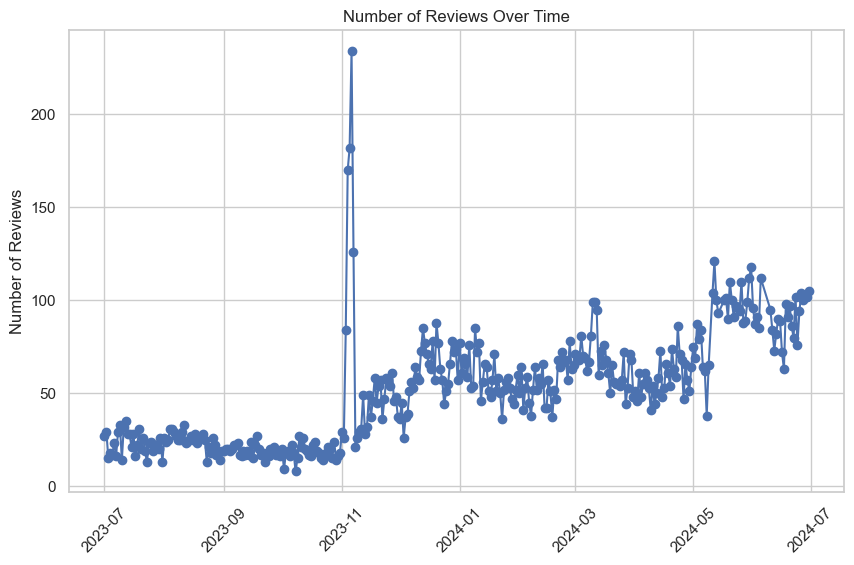

In [29]:
# group by 'at' column and count the number of records for each date
df_grouped = df.groupby(df['at'].dt.date).size()

# number of records over time
plt.figure(figsize=(10, 6))
df_grouped.plot(kind='line', marker='o')
plt.title('Number of Reviews Over Time')
plt.xlabel('')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## Class frequency

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='rating'>

Text(0.5, 1.0, 'Count of Ratings')

Text(0.5, 0, '')

Text(0, 0.5, 'Count')

(array([0, 1, 2]),
 [Text(0, 0, 'bad'), Text(1, 0, 'good'), Text(2, 0, 'neutral')])

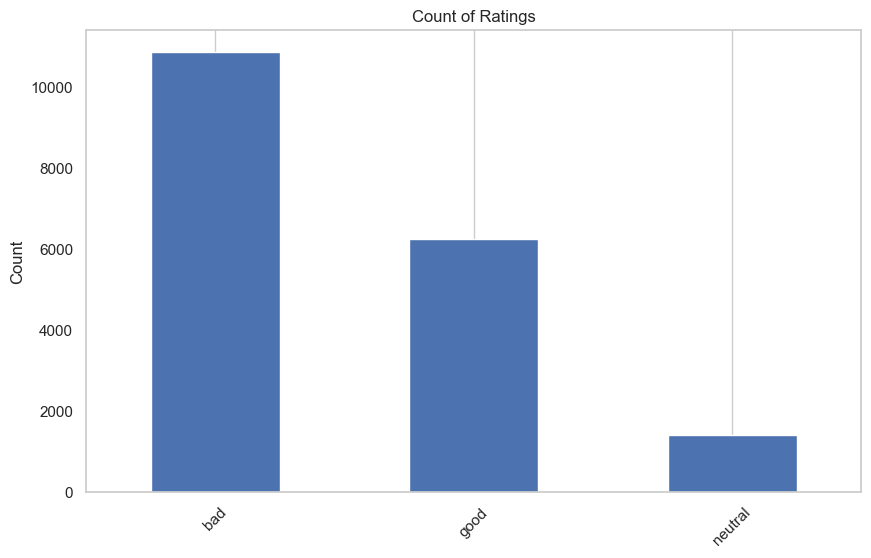

In [30]:
# count the occurrences of each class in the "rating" column
rating_counts = df['rating'].value_counts()

# plot the data
plt.figure(figsize=(10, 6))
rating_counts.plot(kind='bar')
plt.title('Count of Ratings')
plt.xlabel('')
plt.ylabel('Count')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

## Distribution of review lengths

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='length', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of Review Lengths')

Text(0.5, 0, 'Review Length')

Text(0, 0.5, 'Frequency')

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(-20.0, 0, '−20'),
  Text(0.0, 0, '0'),
  Text(20.0, 0, '20'),
  Text(40.0, 0, '40'),
  Text(60.0, 0, '60'),
  Text(80.0, 0, '80'),
  Text(100.0, 0, '100'),
  Text(120.0, 0, '120')])

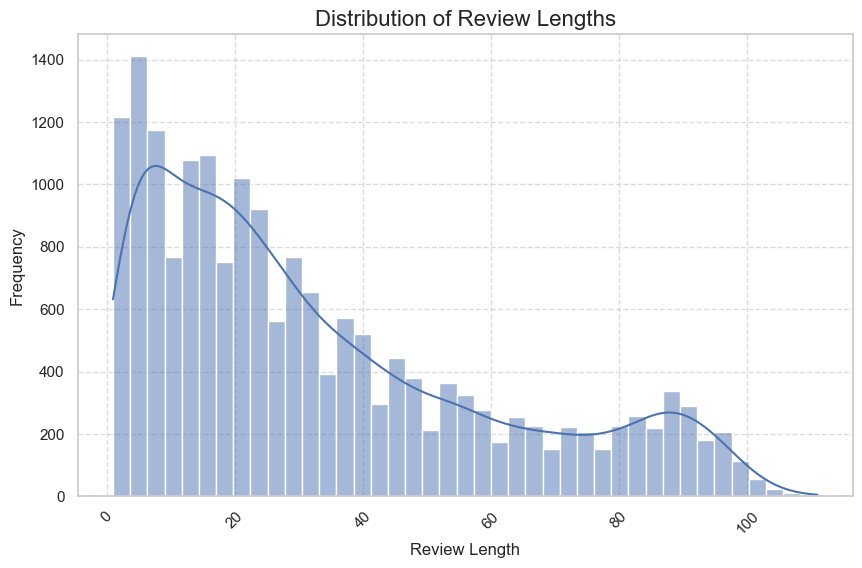

In [31]:
df['length'] = df['content'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='length', kde=True)
plt.title('Distribution of Review Lengths', fontsize=16)
plt.xlabel('Review Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

In [32]:
show_ends(df)

,at,content,rating,length
0,2023-07-01 00:59:23,"I don't know what happened but suddenly I'm unable to add any items to my cart. I get a repeated error message that the item cannot be shipped to my address or any pickup address for that matter! What is this?! And you can't get through to any customer service representatives yet, I assume they're dealing with a flood of reports. Did Amazon just go under?",bad,66
1,2023-07-01 01:32:17,Amazon has ruined the user experience. The menu at the bottom-right on Android no longer opens. Can't see any options. Can't see my past orders. Doesn't Amazon test the app's updates before releasing them?,bad,34
2,2023-07-01 03:43:55,"App doesn't switch pages properly and shipping is always a lie. Everytime I order it tells me that order is on way, when infact it's just paperwork printed. Then it tells me package is on the way when they have called for pickup. It the tells me it's almost here when in fact it is simply at first station. Today it tells my it is at my centre when it only is prepped at origin shipping center. What is the point of all the shipping lies, it never makes sense beyond charge upon ship notice",neutral,95
3,2023-07-01 03:55:16,I am always pleased with Amazon ordering and delivery service. If people would read descriptions more closely many headaches could be alleviated. I have been a prime since they started prime. I have only once gotten the wrong item. Had replacement in 2 days.,good,44
4,2023-07-01 05:03:57,2023 July New phone and still not working right but Amazon doesn't care as long as you can still buy things! For some reason the voice to text is not working. Looked for an upgrade but there was none. All my other apps this feature works. It's working right now but not in the app.,bad,55
18492,2024-06-30 19:21:13,"I love it can find ALMOST EVERYTHING I say that because they don't have the flipper 0 due to it ""being a credit card ripper"" but it's not and nothing like that",good,32
18493,2024-06-30 19:55:24,Cd Nooreew Soomoog.I Think that,neutral,5
18494,2024-06-30 20:21:06,"Since we moved to an assisted living facility because of my wife's stroke, with my need to stay with her, we have depended on Amazon for shopping. I have learned to overcome much of the lack of help.",good,38
18495,2024-06-30 20:28:09,Una aplicación confiable y cuyas entregas se realizan normalmente de manera rápida.,good,12
18496,2024-06-30 20:52:41,Great,good,1


## Text cleaning

In [33]:
ADDITIONAL_STOPWORDS = []

def clean(sentence):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    sentence = (unicodedata.normalize('NFKD', sentence)
        .encode('ascii', 'ignore')
        .decode('utf-8', 'ignore')
        .lower())
    words = re.sub(r'[^\w\s]', '', sentence).split()
    word_list = [wnl.lemmatize(word) for word in words if word not in stopwords]
    return word_list

clean('The quick brown fox jumps over the lazy dog. Ignore me.')

['quick', 'brown', 'fox', 'jump', 'lazy', 'dog', 'ignore']

In [34]:
# applying the function to create the 'words' column
df['words'] = df['content'].apply(clean)

In [35]:
show_ends(df)

,at,content,rating,length,words
0,2023-07-01 00:59:23,"I don't know what happened but suddenly I'm unable to add any items to my cart. I get a repeated error message that the item cannot be shipped to my address or any pickup address for that matter! What is this?! And you can't get through to any customer service representatives yet, I assume they're dealing with a flood of reports. Did Amazon just go under?",bad,66,"[dont, know, happened, suddenly, im, unable, add, item, cart, get, repeated, error, message, item, cannot, shipped, address, pickup, address, matter, cant, get, customer, service, representative, yet, assume, theyre, dealing, flood, report, amazon, go]"
1,2023-07-01 01:32:17,Amazon has ruined the user experience. The menu at the bottom-right on Android no longer opens. Can't see any options. Can't see my past orders. Doesn't Amazon test the app's updates before releasing them?,bad,34,"[amazon, ruined, user, experience, menu, bottomright, android, longer, open, cant, see, option, cant, see, past, order, doesnt, amazon, test, apps, update, releasing]"
2,2023-07-01 03:43:55,"App doesn't switch pages properly and shipping is always a lie. Everytime I order it tells me that order is on way, when infact it's just paperwork printed. Then it tells me package is on the way when they have called for pickup. It the tells me it's almost here when in fact it is simply at first station. Today it tells my it is at my centre when it only is prepped at origin shipping center. What is the point of all the shipping lies, it never makes sense beyond charge upon ship notice",neutral,95,"[app, doesnt, switch, page, properly, shipping, always, lie, everytime, order, tell, order, way, infact, paperwork, printed, tell, package, way, called, pickup, tell, almost, fact, simply, first, station, today, tell, centre, prepped, origin, shipping, center, point, shipping, lie, never, make, sense, beyond, charge, upon, ship, notice]"
3,2023-07-01 03:55:16,I am always pleased with Amazon ordering and delivery service. If people would read descriptions more closely many headaches could be alleviated. I have been a prime since they started prime. I have only once gotten the wrong item. Had replacement in 2 days.,good,44,"[always, pleased, amazon, ordering, delivery, service, people, would, read, description, closely, many, headache, could, alleviated, prime, since, started, prime, gotten, wrong, item, replacement, 2, day]"
4,2023-07-01 05:03:57,2023 July New phone and still not working right but Amazon doesn't care as long as you can still buy things! For some reason the voice to text is not working. Looked for an upgrade but there was none. All my other apps this feature works. It's working right now but not in the app.,bad,55,"[2023, july, new, phone, still, working, right, amazon, doesnt, care, long, still, buy, thing, reason, voice, text, working, looked, upgrade, none, apps, feature, work, working, right, app]"
18492,2024-06-30 19:21:13,"I love it can find ALMOST EVERYTHING I say that because they don't have the flipper 0 due to it ""being a credit card ripper"" but it's not and nothing like that",good,32,"[love, find, almost, everything, say, dont, flipper, 0, due, credit, card, ripper, nothing, like]"
18493,2024-06-30 19:55:24,Cd Nooreew Soomoog.I Think that,neutral,5,"[cd, nooreew, soomoogi, think]"
18494,2024-06-30 20:21:06,"Since we moved to an assisted living facility because of my wife's stroke, with my need to stay with her, we have depended on Amazon for shopping. I have learned to overcome much of the lack of help.",good,38,"[since, moved, assisted, living, facility, wife, stroke, need, stay, depended, amazon, shopping, learned, overcome, much, lack, help]"
18495,2024-06-30 20:28:09,Una aplicación confiable y cuyas entregas se realizan normalmente de manera rápida.,good,12,"[una, aplicacion, confiable, cuyas, entregas, se, realizan, normalmente, de, manera, rapida]"
18496,2024-06-30 20:52:41,Great,good,1,[great]


## Unique words

In [36]:
# filter to include only 'good' and 'bad' ratings
filtered_df = df[df['rating'].isin(['good', 'bad'])]

# function to count and sort words by frequency
def count_and_sort_words(words_list):
    # flatten the list of words
    flattened_words = [word for sublist in words_list for word in sublist]
    # count occurrences of each word
    word_counts = Counter(flattened_words)
    # Sort words by frequency (most frequent first)
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    return sorted_words

# group by 'rating' and apply the function
grouped = filtered_df.groupby('rating')['words'].agg(list)
sorted_words_per_rating = grouped.apply(count_and_sort_words)

# create a dictionary to construct the final dataframe
data_dict = {
    'good': [word for word, _ in sorted_words_per_rating['good']],
    'bad': [word for word, _ in sorted_words_per_rating['bad']]
}

# determine the longer list of words (in case good and bad have different lengths)
max_length = max(len(data_dict['good']), len(data_dict['bad']))

# pad the lists with None values to ensure equal length
data_dict['good'] += [None] * (max_length - len(data_dict['good']))
data_dict['bad'] += [None] * (max_length - len(data_dict['bad']))

# create the final dataframe
final_df = pd.DataFrame(data_dict)

final_df[:20]

,good,bad
0,amazon,app
1,app,amazon
2,love,order
3,shopping,get
4,great,item
5,easy,time
6,good,cant
7,delivery,dont
8,always,prime
9,item,day


## N-grams

In [37]:
# function to convert tuple to string without parentheses and commas
def tuple_to_str(tup):
    return ' '.join(map(str, tup))

# function to format ngram table
def format_ngrams(ngram):
    ngram['Phrase Words'] = ngram['Phrase'].apply(tuple_to_str)
    return ngram.drop(columns=['Phrase'])

def viz_ngrams(df, rating):
    # filter to include only 'good' ratings and concatenate content
    content = ' '.join(df[df['rating'] == rating]['content'])
    
    # tokenize the content into words
    tokens = word_tokenize(content.lower())  # Lowercase for consistency
    
    # generate bigrams, trigrams, and quadgrams
    bigrams = list(ngrams(tokens, 2))
    trigrams = list(ngrams(tokens, 3))
    quadgrams = list(ngrams(tokens, 4))
    
    # count occurrences of each ngram
    bigram_counts = Counter(bigrams)
    trigram_counts = Counter(trigrams)
    quadgram_counts = Counter(quadgrams)
    
    # convert to dataframes
    df_bigrams = pd.DataFrame(bigram_counts.most_common(10), columns=['Phrase', 'Frequency'])
    df_trigrams = pd.DataFrame(trigram_counts.most_common(10), columns=['Phrase', 'Frequency'])
    df_quadgrams = pd.DataFrame(quadgram_counts.most_common(10), columns=['Phrase', 'Frequency'])
    
    print("\n\n")
    print("=======================================\n BIGRAMS")
    print("---------------------------------------\n")
    print(format_ngrams(df_bigrams))
    print("\n\n")
    print("=======================================\n TRIGRAMS")
    print("---------------------------------------\n")
    print(format_ngrams(df_trigrams))
    print("\n\n")
    print("=======================================\n QUADGRAMS")
    print("---------------------------------------\n")
    print(format_ngrams(df_quadgrams))

    # plotting using seaborn
    plt.figure(figsize=(12, 20))
    
    # plot for bigrams
    plt.subplot(311)
    sns.barplot(x='Frequency', y='Phrase Words', data=df_bigrams, legend=False)
    plt.title('Top 10 Bigrams')
    plt.xlabel('Frequency')
    plt.ylabel('Bigram')
    
    # plot for trigrams
    plt.subplot(312)
    sns.barplot(x='Frequency', y='Phrase Words', data=df_trigrams, legend=False)
    plt.title('Top 10 Trigrams')
    plt.xlabel('Frequency')
    plt.ylabel('Trigram')
    
    # plot for quadgrams
    plt.subplot(313)
    sns.barplot(x='Frequency', y='Phrase Words', data=df_quadgrams, legend=False)
    plt.title('Top 10 Quadgrams')
    plt.xlabel('Frequency')
    plt.ylabel('Quadgram')
    
    plt.tight_layout()
    plt.show()

    # generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(content)
    
    # plotting word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {rating.capitalize()} Ratings')
    plt.show()




 BIGRAMS
---------------------------------------

   Frequency Phrase Words
0       1198          . i
1        666        it 's
2        617          ! !
3        586       i love
4        442      easy to
5        376       i have
6        344  love amazon
7        338        , and
8        331     amazon .
9        327      the app



 TRIGRAMS
---------------------------------------

   Frequency        Phrase Words
0        255               ! ! !
1        210            . i love
2        188         easy to use
3        187       i love amazon
4        170             . it 's
5        156            i do n't
6        114  shopping on amazon
7        109            . i have
8         92     i love shopping
9         86            i ca n't



 QUADGRAMS
---------------------------------------

   Frequency             Phrase Words
0         76                  ! ! ! !
1         70          . i love amazon
2         50  love shopping on amazon
3         45          easy to use and

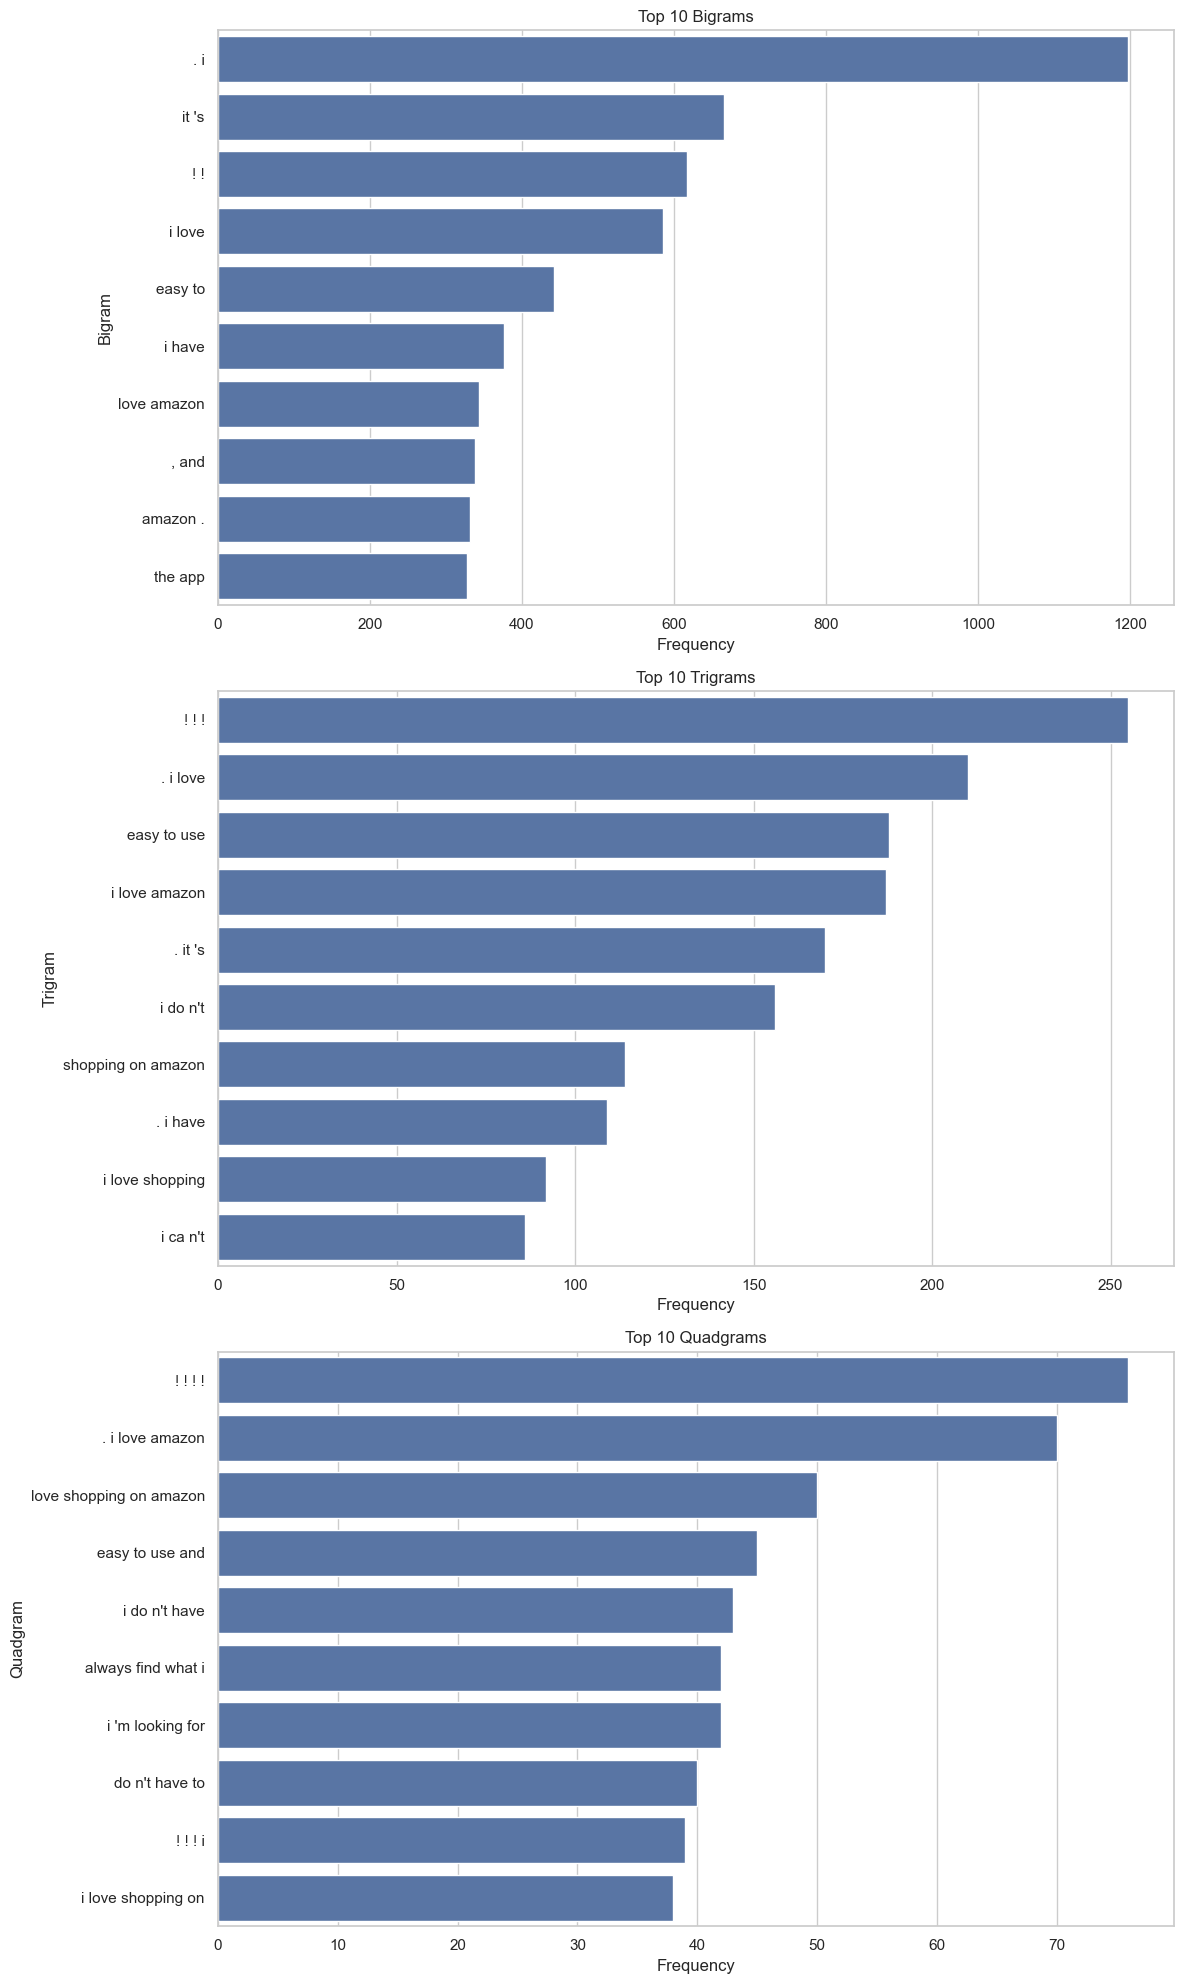

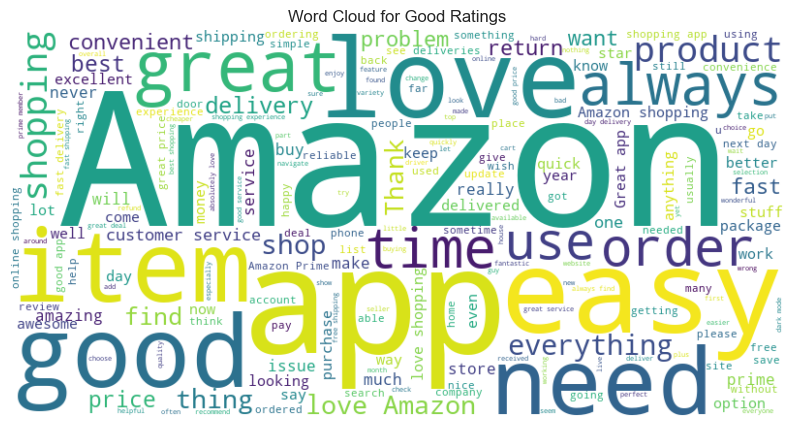

In [38]:
viz_ngrams(df, 'good')




 BIGRAMS
---------------------------------------

   Frequency Phrase Words
0       3944          . i
1       2437      the app
2       2000        it 's
3       1735       ca n't
4       1690          ! !
5       1627       do n't
6       1335         . it
7       1245       i have
8       1227         i 'm
9       1135        . the



 TRIGRAMS
---------------------------------------

   Frequency Phrase Words
0        885        ! ! !
1        708     i ca n't
2        638     i do n't
3        570      . it 's
4        397     . i have
5        357    the app .
6        346       . i 'm
7        332    i have to
8        282    . the app
9        279      . i 've



 QUADGRAMS
---------------------------------------

   Frequency   Phrase Words
0        440        ! ! ! !
1        225     . i do n't
2        162     . i ca n't
3        122  i ca n't even
4        119  i do n't know
5        116  wo n't let me
6        109  i do n't want
7        108        ? ? ? ?
8         94  

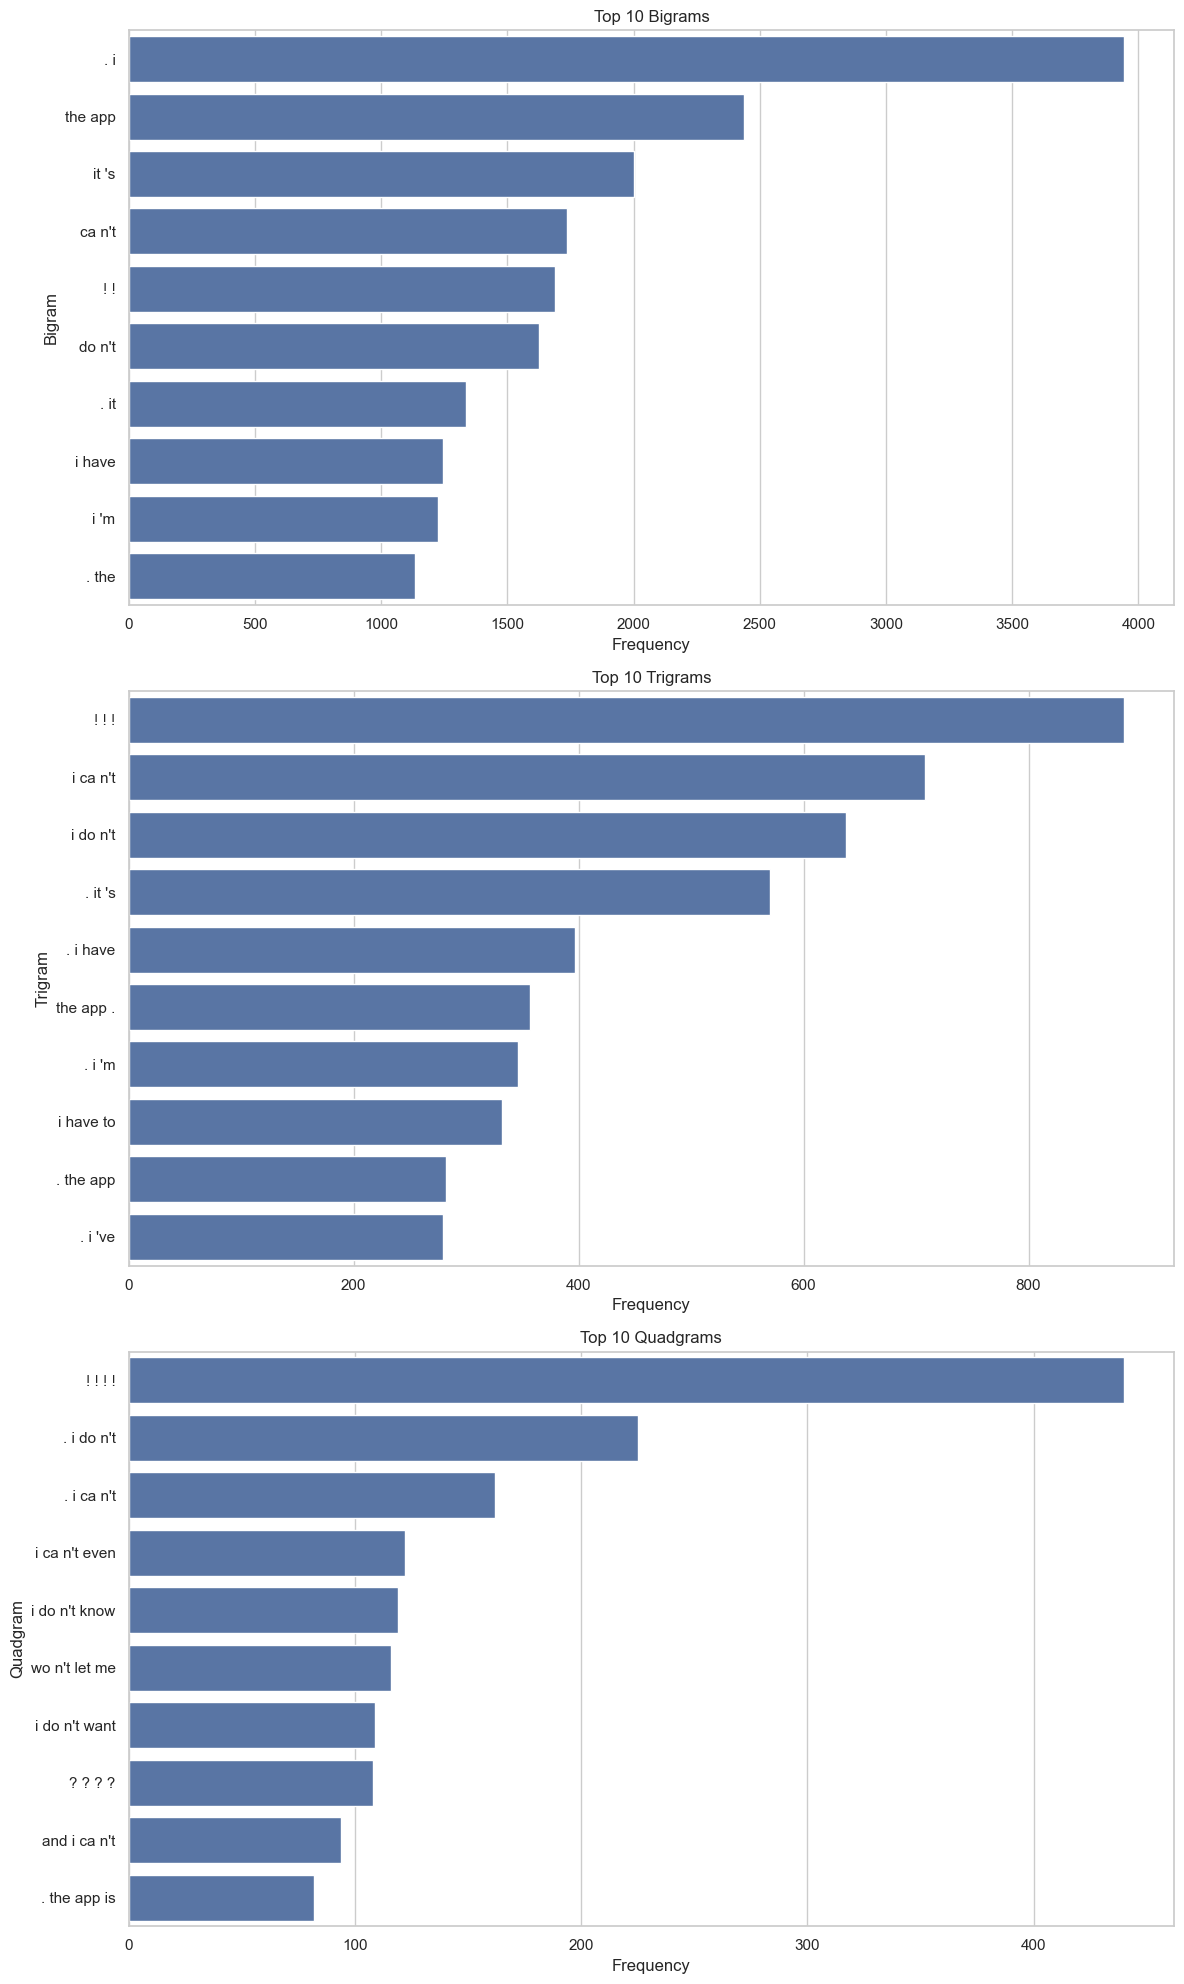

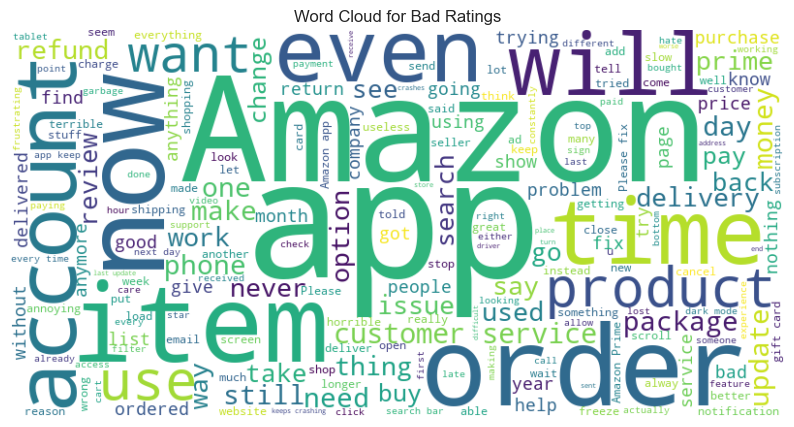

In [39]:
viz_ngrams(df, 'bad')

In [40]:
show_ends(df)

,at,content,rating,length,words
0,2023-07-01 00:59:23,"I don't know what happened but suddenly I'm unable to add any items to my cart. I get a repeated error message that the item cannot be shipped to my address or any pickup address for that matter! What is this?! And you can't get through to any customer service representatives yet, I assume they're dealing with a flood of reports. Did Amazon just go under?",bad,66,"[dont, know, happened, suddenly, im, unable, add, item, cart, get, repeated, error, message, item, cannot, shipped, address, pickup, address, matter, cant, get, customer, service, representative, yet, assume, theyre, dealing, flood, report, amazon, go]"
1,2023-07-01 01:32:17,Amazon has ruined the user experience. The menu at the bottom-right on Android no longer opens. Can't see any options. Can't see my past orders. Doesn't Amazon test the app's updates before releasing them?,bad,34,"[amazon, ruined, user, experience, menu, bottomright, android, longer, open, cant, see, option, cant, see, past, order, doesnt, amazon, test, apps, update, releasing]"
2,2023-07-01 03:43:55,"App doesn't switch pages properly and shipping is always a lie. Everytime I order it tells me that order is on way, when infact it's just paperwork printed. Then it tells me package is on the way when they have called for pickup. It the tells me it's almost here when in fact it is simply at first station. Today it tells my it is at my centre when it only is prepped at origin shipping center. What is the point of all the shipping lies, it never makes sense beyond charge upon ship notice",neutral,95,"[app, doesnt, switch, page, properly, shipping, always, lie, everytime, order, tell, order, way, infact, paperwork, printed, tell, package, way, called, pickup, tell, almost, fact, simply, first, station, today, tell, centre, prepped, origin, shipping, center, point, shipping, lie, never, make, sense, beyond, charge, upon, ship, notice]"
3,2023-07-01 03:55:16,I am always pleased with Amazon ordering and delivery service. If people would read descriptions more closely many headaches could be alleviated. I have been a prime since they started prime. I have only once gotten the wrong item. Had replacement in 2 days.,good,44,"[always, pleased, amazon, ordering, delivery, service, people, would, read, description, closely, many, headache, could, alleviated, prime, since, started, prime, gotten, wrong, item, replacement, 2, day]"
4,2023-07-01 05:03:57,2023 July New phone and still not working right but Amazon doesn't care as long as you can still buy things! For some reason the voice to text is not working. Looked for an upgrade but there was none. All my other apps this feature works. It's working right now but not in the app.,bad,55,"[2023, july, new, phone, still, working, right, amazon, doesnt, care, long, still, buy, thing, reason, voice, text, working, looked, upgrade, none, apps, feature, work, working, right, app]"
18492,2024-06-30 19:21:13,"I love it can find ALMOST EVERYTHING I say that because they don't have the flipper 0 due to it ""being a credit card ripper"" but it's not and nothing like that",good,32,"[love, find, almost, everything, say, dont, flipper, 0, due, credit, card, ripper, nothing, like]"
18493,2024-06-30 19:55:24,Cd Nooreew Soomoog.I Think that,neutral,5,"[cd, nooreew, soomoogi, think]"
18494,2024-06-30 20:21:06,"Since we moved to an assisted living facility because of my wife's stroke, with my need to stay with her, we have depended on Amazon for shopping. I have learned to overcome much of the lack of help.",good,38,"[since, moved, assisted, living, facility, wife, stroke, need, stay, depended, amazon, shopping, learned, overcome, much, lack, help]"
18495,2024-06-30 20:28:09,Una aplicación confiable y cuyas entregas se realizan normalmente de manera rápida.,good,12,"[una, aplicacion, confiable, cuyas, entregas, se, realizan, normalmente, de, manera, rapida]"
18496,2024-06-30 20:52:41,Great,good,1,[great]


# Modeling

In [41]:
# encode categorical target
label_encoder = LabelEncoder()
df['encoded_rating'] = label_encoder.fit_transform(df['rating'])

tv = TfidfVectorizer(max_features=10_000)

# split data into training and testing sets
X = tv.fit_transform(df['content']).toarray()  # Assuming numerical features
y = df['encoded_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=493)

In [42]:
def model_evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_matrix = pd.DataFrame(data=cm, index=['Actual ' + str(i) for i in range(len(cm))], columns=['Predicted ' + str(i) for i in range(len(cm))])
    print(classification_report(y_test, y_pred))
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    print('Accuracy : ', accuracy)
    print('Misclassification Rate : ', misclass)
    plt.show()
    print("\n")
    
def fit_model(models, X_train, y_train, X_test, y_test, cross_val=False, cv_val=4):
    for name, model in models.items():
        print(name, "\n")
        model.fit(X_train, y_train)
        model_evaluation(model, X_test, y_test)
        if cross_val:
            cv_scores = cross_val_score(model, X_train, y_train, cv=cv_val)
            print("Cross Validation Scores : ", cv_scores)
            print("Mean Cross Validation Score : ", np.mean(cv_scores))
            print("\n")

Logistic Regression 

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      2131
           1       0.91      0.83      0.87      1292
           2       0.29      0.02      0.03       277

    accuracy                           0.85      3700
   macro avg       0.68      0.61      0.60      3700
weighted avg       0.81      0.85      0.82      3700

Accuracy :  0.8494594594594594
Misclassification Rate :  0.15054054054054056


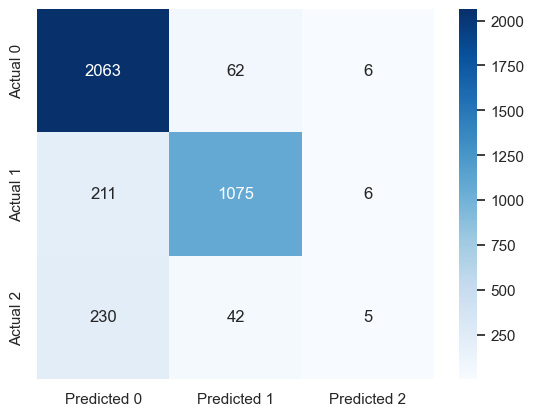



Cross Validation Scores :  [0.85189189 0.84968911 0.85104082 0.84833739]
Mean Cross Validation Score :  0.8502398018456413


Random Forest 

              precision    recall  f1-score   support

           0       0.78      0.97      0.86      2131
           1       0.92      0.75      0.82      1292
           2       0.25      0.00      0.01       277

    accuracy                           0.82      3700
   macro avg       0.65      0.57      0.56      3700
weighted avg       0.79      0.82      0.79      3700

Accuracy :  0.8186486486486486
Misclassification Rate :  0.1813513513513514


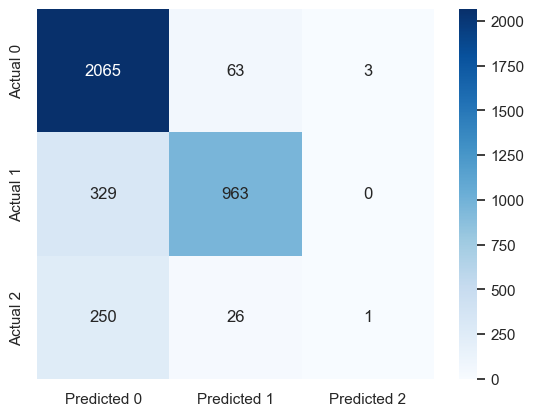



Cross Validation Scores :  [0.82027027 0.8253582  0.8172479  0.80589348]
Mean Cross Validation Score :  0.8171924661888165


XGBoost 

              precision    recall  f1-score   support

           0       0.80      0.97      0.87      2131
           1       0.92      0.77      0.84      1292
           2       0.18      0.01      0.03       277

    accuracy                           0.83      3700
   macro avg       0.63      0.58      0.58      3700
weighted avg       0.79      0.83      0.80      3700

Accuracy :  0.8283783783783784
Misclassification Rate :  0.17162162162162165


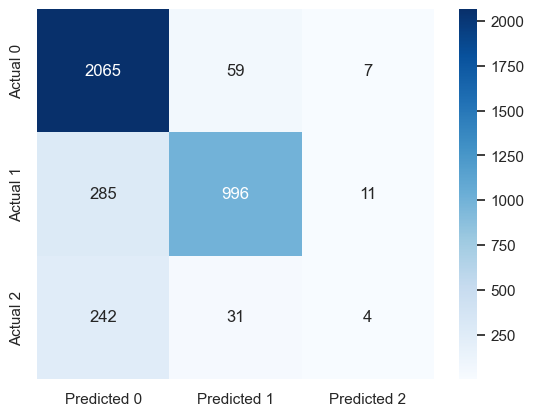



Cross Validation Scores :  [0.82864865 0.83103541 0.82454717 0.83265747]
Mean Cross Validation Score :  0.8292221783827624




In [43]:
xgb_model = xgb.XGBClassifier()

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': xgb_model,
}

fit_model(models, X_train, y_train, X_test, y_test, cross_val=True)

## Save dataframe

In [44]:
df.to_csv('../data/documents.csv', index=False)